[DIY Disease Tracking Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) (C) Fabrizio Smeraldi, 2020,2024 ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)). This notebook is released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/).

# DIY Disease Tracking Dashboard

This is a template for your DIY Disease Tracking Dashboard, to which you can add the code you developed in the previous notebooks. The dashboard will be displayed using [voila](https://voila.readthedocs.io/en/stable/index.html), a Python dashboarding tool that converts notebooks to standalone dashboards. Contrary to the other libraries we have seen, the ```voila``` package must be installed using *pip* or *conda* but it does not need to be imported - it rather acts at the level of the notebook server. Package ```voila``` is already installed on the QMUL JupyterHub as well as in the Binder - to install it locally, follow the [instructions](https://voila.readthedocs.io/en/stable/install.html) online.

Broadly speaking, Voila acts by **running all the cells in your notebook** when the dashboard is first loaded; it then hides all code cells and displays all markdown cells and any outputs, including widgets. However, the code is still there in the background and handles any interaction with the widgets. To view this dashboard template rendered in Voila click [here](https://mybinder.org/v2/gh/fsmeraldi/diy-covid19dash/main?urlpath=%2Fvoila%2Frender%2FDashboard.ipynb).

In [1]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import json

In [15]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

#function to convert a date string into a pandas datetime object
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

## Load initial data from disk

You should include "canned" data in ```.json``` files along with your dashboard. When the dashboard starts, it should load that data and assign it as a dictionary to the ```jsondata``` variable (the code below will be hidden when the dashboard is rendered by Voila).

In [16]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
jsondata={}

In [17]:
#load the data
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("cases.json", "rt") as INFILE:
    cases=json.load(INFILE)
with open("deaths.json", "rt") as INFILE:
    deaths=json.load(INFILE)

with open("influenzaAdmission.json", "rt") as INFILE:
    influenzaAdmissions=json.load(INFILE)   
with open("bedsDay.json", "rt") as INFILE:
    bedsDay=json.load(INFILE)
# with open("COVID-19_cases_casesByDay.json", "rt") as INFILE:
#     CovidDay=json.load(INFILE)
    
#compare the pcr tests for covid and influenza
with open("CovidPCRlatest.json", "rt") as INFILE:
    CovidPCR=json.load(INFILE)
with open("influenzaPCRlatest.json", "rt") as INFILE:
    influenzaPCR=json.load(INFILE)



In [18]:
pcrTests = {}
for dataset in [CovidPCR, influenzaPCR]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in pcrTests:
            pcrTests[date]={}
        pcrTests[date][metric]=value
        
    
 #Admissions
totalAdmissions={}
for dataset in [admissions, influenzaAdmissions]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in totalAdmissions:
            totalAdmissions[date]={}
        totalAdmissions[date][metric]=value

#Covid Cases vs Covid Occupied Beds
covidDayBeds={}
for dataset in [bedsDay, cases]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in covidDayBeds:
            covidDayBeds[date]={}
        covidDayBeds[date][metric]=value

## Wrangle the data

The dashboard should contain the logic to wrangle the raw data into a ```DataFrame``` (or more than one, as required) that will be used for plotting. The wrangling code should be put into a function and called on the data from the JSON file (we'll need to call it again on any data downloaded from the API).  In this template, we just pretend we are wrangling ```rawdata``` and instead generate a dataframe with some random data

2017-07-03 00:00:00  to  2024-11-11 00:00:00


/var/folders/0g/05700__976v93g3f39_3753r0000gn/T/ipykernel_5627/886783915.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0.0, inplace=True)


<Axes: >

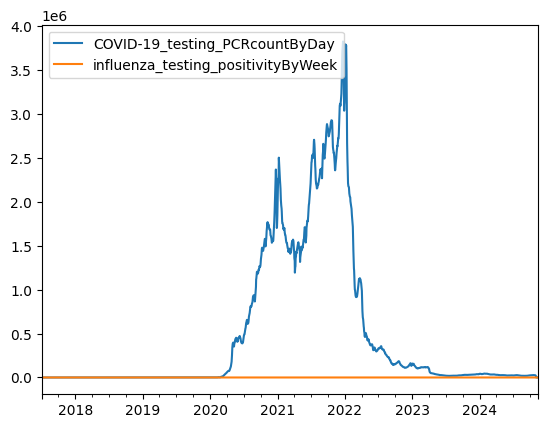

In [42]:
series=wdg.SelectMultiple(
    options=['cases', 'admissions', 'deaths'],
    value=['cases', 'admissions', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

def wrangle_data_multiple(rawdata, anotherdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
#create a new dictionary to store the data
    newJson={}
    metricList=[]
    for dataset in [rawdata, anotherdata]:
        for entry in dataset:
            date=entry["date"]
            metric=entry["metric"]
            value =entry["metric_value"]
            if date not in newJson:
                newJson[date]={}
            newJson[date][metric]=value
            if metric not in metricList:
                metricList.append(metric)
    
    #dates
    dates=list(newJson.keys())
    dates.sort()
    
     #convert start and end dates to pandas format for the index data range
    startDate=parse_date(dates[0])
    endDate=parse_date(dates[-1])
    print (startDate, ' to ', endDate)
    
    
    index = pd.date_range(startDate, endDate, freq='D')
    df=pd.DataFrame(index=index, columns=[metric for metric in metricList])
    # df=pd.DataFrame(index=index columns=['One', 'Two'])
    # we have no real data to wrangle, so we just generate two random walks.
    # one=two=0.0
    # for i in range(0,100):
    #     df.loc[i,'One']=one
    #     df.loc[i,'Two']=two
    #     one+=np.random.randn()
    #     two+=2*np.random.randn()
    # return df
    metrics ={metric:metric for metric in metricList}
    
    for date, entry in newJson.items(): # each entry is a dictionary with cases, admissions and deaths
        pd_date=parse_date(date) # convert to Pandas format
        for column in [metric for metric in metricList]: # each column is a metric
            metric_name=metrics[column]
            # do not assume all values are there for every date - if a value is not available, insert a 0.0
            value= entry.get(metric_name, 0.0)
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            df.loc[date, column]=value
    # fill in any remaining "holes" due to missing dates
    df.fillna(0.0, inplace=True)
    return df

# putting the wrangling code into a function allows you to call it again after refreshing the data through 
# the API. You should call the function directly on the JSON data when the dashboard starts, by including 
# the call in this cell as below:
df=wrangle_data(CovidPCR, influenzaPCR) # df is the dataframe for plotting
df.plot()

## Download current data

Give your users an option to refresh the dataset - a "refresh" button will do. The button callback should
* call the code that accesses the API and download some fresh raw data;
* wrangle that data into a dataframe and update the corresponding (global) variable for plotting (here, ```df```);
* optionally: force a redraw of the graph and give the user some fredback.

Once you get it to work, you may want to wrap your API call inside an exception handler, so that the user is informed, the "canned" data are not overwritten and nothing crashes if for any reason the server cannot be reached or data are not available.

After you refresh the data, graphs will not update until the user interacts with a widget. You can trick ```iPywidgets``` into redrawing the graph by simulating interaction, as in the ```refresh_graph``` function we define in the Graph and Analysis section below.

In this example, clicking on the button below just generates some more random data and refreshes the graph. The button should read *Fetch Data*. If you see anything else, take a deep breath :)

In [34]:
import requests
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [ ]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 

def access_api( topic, metric):
    """ Accesses the UKHSA API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
    structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "COVID-19",
           "geography_type": "Nation", 
           "geography": "England"}
    structure["metric"]="COVID-19_cases_casesByDay" 
    api=APIwrapper(**structure)
    data=api.get_all_pages()
    return data # return data read from the API

In [ ]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # The function needs to be adapted to your graph; you can omit this call
    # in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. If you are 
    # implementing error handling, you can use icons "unlink" or "times" and 
    # change the button text to "Unavailable" when the api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='PANIC', # you may want to change this...
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='exclamation-triangle'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='danger', description='PANIC', icon='exclamation-triangle', style=ButtonStyle(), tooltip='…

TypeError: wrangle_data() missing 1 required positional argument: 'anotherdata'

TypeError: wrangle_data() missing 1 required positional argument: 'anotherdata'

## Graphs and Analysis

Include at least one graph with interactive controls, as well as some instructions for the user and/or comments on what the graph represents and how it should be explored (this example shows two random walks)

In [40]:
def plot_random_walk(walk):
    """ Our sample graph plotting function """
    df[walk].plot()
    plt.show() # important! update won't work properly without this

# a sample widget
whichwalk=wdg.Dropdown(
    options=['COVID-19_cases_casesByDay'],
    value='COVID-19_cases_casesByDay',
    description='Walk no: ',
    disabled=False,
)

def refresh_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current=whichwalk.value
    if current==whichwalk.options[0]:
        other=whichwalk.options[1]
    else:
        other=whichwalk.options[0]
    whichwalk.value=other # forces the redraw
    whichwalk.value=current # now we can change it back
    
# connect the plotting function and the widget    
graph=wdg.interactive_output(plot_random_walk, {'walk': whichwalk})

# actually displays the graph
display(whichwalk, graph)

Dropdown(description='Walk no: ', options=('COVID-19_cases_casesByDay',), value='COVID-19_cases_casesByDay')

Output()

## Deploying the dashboard

Once your code is ready and you are satisfied with the appearance of the graphs, replace all the text boxes above with the explanations you would like a dashboard user to see. The next step is deploying the dashboard online - there are several [options](https://voila.readthedocs.io/en/stable/deploy.html) for this, we suggest deploying as a [Binder](https://mybinder.org/). This is basically the same technique that has been used to package this tutorial and to deploy this template dashboard. The instructions may seem a bit involved, but the actual steps are surprisingly easy - we will be going through them together during a live session. You will need an account on [GitHub](https://github.com/) for this - if you don't have one already, now it's the time to create it. 

**Author and License** Remember that if you deploy your dashboard as a Binder it will be publicly accessible. Change the copyright notice and take credit for your work! Also acknowledge your sources and the conditions of the license by including this notice: "Based on UK Government [data](https://ukhsa-dashboard.data.gov.uk/) published by the [UK Health Security Agency](https://www.gov.uk/government/organisations/uk-health-security-agency) and on the [DIY Disease Tracking Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) by Fabrizio Smeraldi. Released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/)."